In [ ]:
# Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
# Model related imports
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data loading:

In [ ]:
with open('/content/gdrive/My Drive/Notebooks Colab/cleanDF.pickle', 'rb') as handle:
    df = pickle.load(handle)
X = df.copy().drop('HasDetections', 1)
y = df.copy()['HasDetections']
del df

categoricalColumns = list(X.select_dtypes(include='category').columns)
numericalColumns = list(X.select_dtypes(exclude='category').columns)

Normalizing the columns to have mean 0 and standard deviation of 1:

In [ ]:
for column in numericalColumns:
    X[column] = ((X[column] - np.mean(X[column])) / np.std(X[column])).astype('float64')

Splitting the data set in train (99 %) and validation (1%) sets:

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.01, stratify=y, random_state=11)

We define the One-Hot encoder for categorical variables and apply it to the validation set. To avoid excessive memory consumption we will encode the train set at each mini-batch.

In [ ]:
uniques = {}
for column in categoricalColumns:
    uniques[column] = X[column].unique()

uniquesDF = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in uniques.items() ]))

categoricalEncoder = OneHotEncoder(handle_unknown='ignore', dtype='uint8', sparse=True)
categoricalEncoder.fit(uniquesDF.astype(str))

xValNumerical = xVal[numericalColumns].values
xValCategorical = xVal[categoricalColumns]
xValCategorical = categoricalEncoder.transform(xValCategorical)
xVal = np.concatenate([xValNumerical, scipy.sparse.csr_matrix.toarray(xValCategorical)], axis=1)
del xValNumerical
del xValCategorical
del uniquesDF

An iterator to yield mini-batches:

In [ ]:
def iterateMiniBatches(inputs, targets, batchSize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchSize + 1, batchSize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchSize]
        else:
            excerpt = slice(start_idx, start_idx + batchSize)
        yield inputs.iloc[excerpt], targets.iloc[excerpt]

Training params:

In [ ]:
classes = y.unique()
numEpochs = 10
batchSize = 2**10
numBatches = xTrain.shape[0] // batchSize

# Neural net

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', batch_size=batchSize, max_iter=1, learning_rate_init=0.00001)

for n in range(numEpochs):
    batchCounter = 0
    print(f"---------------------- EPOCH {n + 1} ----------------------")
    for batch in iterateMiniBatches(xTrain, yTrain, batchSize, shuffle=True):
        batchCounter += 1
        xBatch, yBatch = batch
        xBatchNumerical = xBatch[numericalColumns].values
        xBatchCategorical = xBatch[categoricalColumns]
        xBatchCategorical = categoricalEncoder.transform(xBatchCategorical)
        xBatch = np.concatenate([xBatchNumerical, scipy.sparse.csr_matrix.toarray(xBatchCategorical)], axis=1)
        model.partial_fit(xBatch, yBatch, classes=classes)
        if batchCounter % 200 == 0:
            print(f"Training batch number {batchCounter} out of {numBatches}")
            print("Batch score: %0.3f" % model.score(xBatch, yBatch))
            print("Test score: %0.3f" % model.score(xVal, yVal))   
    with open(f'/content/gdrive/My Drive/Notebooks Colab/MLPModel_e{n + 1}.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model saved")

---------------------- EPOCH 1 ----------------------
Training batch number 200 out of 8625
Batch score: 0.622
Test score: 0.624
Training batch number 400 out of 8625
Batch score: 0.636
Test score: 0.625
Training batch number 600 out of 8625
Batch score: 0.606
Test score: 0.629
Training batch number 800 out of 8625
Batch score: 0.646
Test score: 0.629
Training batch number 1000 out of 8625
Batch score: 0.626
Test score: 0.630
Training batch number 1200 out of 8625
Batch score: 0.637
Test score: 0.632
Training batch number 1400 out of 8625
Batch score: 0.626
Test score: 0.635
Training batch number 1600 out of 8625
Batch score: 0.641
Test score: 0.634
Training batch number 1800 out of 8625
Batch score: 0.649
Test score: 0.636
Training batch number 2000 out of 8625
Batch score: 0.651
Test score: 0.635
Training batch number 2200 out of 8625
Batch score: 0.637
Test score: 0.637
Training batch number 2400 out of 8625
Batch score: 0.633
Test score: 0.639
Training batch number 2600 out of 8625

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training batch number 1200 out of 8625
Batch score: 0.653
Test score: 0.651
Training batch number 1400 out of 8625
Batch score: 0.630
Test score: 0.651


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_p

Training batch number 1600 out of 8625
Batch score: 0.649


KeyboardInterrupt: ignored

# Results

## Neural net

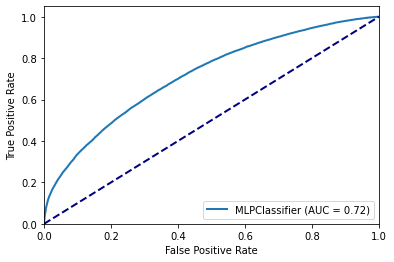

In [ ]:
from sklearn import metrics

with open('/content/gdrive/My Drive/Notebooks Colab/MLPModel_e5.pickle', 'rb') as handle:
    model = pickle.load(handle)

metrics.plot_roc_curve(model, xVal, yVal, lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Submitting

In [ ]:
with open('/content/gdrive/My Drive/Notebooks Colab/cleanDFTest.pickle', 'rb') as handle:
    XTest = pickle.load(handle)

In [ ]:
for column in numericalColumns:
    XTest[column] = ((XTest[column] - np.mean(X[column])) / np.std(X[column])).astype('float64')
del X
del y

## Neural network

In [ ]:
with open('/content/gdrive/My Drive/Notebooks Colab/MLPModel_e5.pickle', 'rb') as handle:
    model = pickle.load(handle)

yHats = []
intervals = list(range(0, XTest.shape[0], 2**16))
for i in range(len(intervals) - 1):
    x = XTest.iloc[intervals[i]:intervals[i + 1]]
    xNumerical = x[numericalColumns].values
    xCategorical = x[categoricalColumns]
    xCategorical = categoricalEncoder.transform(xCategorical)
    x = np.concatenate([xNumerical, scipy.sparse.csr_matrix.toarray(xCategorical)], axis=1)
    yHats += model.predict_proba(x).tolist()
x = XTest.iloc[intervals[-1]:XTest.shape[0]]
xNumerical = x[numericalColumns].values
xCategorical = x[categoricalColumns]
xCategorical = categoricalEncoder.transform(xCategorical)
x = np.concatenate([xNumerical, scipy.sparse.csr_matrix.toarray(xCategorical)], axis=1)
yHats += model.predict_proba(x).tolist()

In [ ]:
yRes = np.array(yHats)[:, 1]
submission = pd.read_csv('/content/gdrive/My Drive/Notebooks Colab/sample_submission.csv')
submission['HasDetections'] = yRes
submission.to_csv('/content/gdrive/My Drive/Notebooks Colab/MLPModel_e5_submission.csv', index=False)
submission.head()